In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
import random 
import os
import pickle

### Memmap data

In [2]:
arr = np.memmap('image_data_raw.npy',mode='r', shape = (150000,275*210))
arr.shape

(150000, 57750)

### Create Base PCA Models on Subset of Data to find optimum n_components

In [13]:
n = arr.shape[0] # how many rows we have in the dataset
fold_size = 4000 # how many rows we feed to IPCA at a time, the divisor of n

performance = {}

for i in range(1, 10):
    idx = np.random.randint(n, size=fold_size)
    pca = PCA(n_components=1000-i*100)
    pca.fit(arr[idx])
    print(f'{i}\t/\t {20}',end='\r',flush=True)
    performance[f'{1000-i*25}'] = np.cumsum(pca.explained_variance_ratio_)

#### Looking at performance it seems like between 200 and 400 components will be ideal

In [14]:
for key in performance.keys():
    print(f'{key}:\t\
    {np.argmax(performance[key] >= 0.5) + 1}\t\
    {np.argmax(performance[key] >= 0.6) + 1}\t\
    {np.argmax(performance[key] >= 0.7) + 1}\t\
    {np.argmax(performance[key] >= 0.8) + 1}\t\
    {np.argmax(performance[key] >= 0.9) + 1}')

975:	    20	    46	    132	    369	    1
950:	    19	    44	    125	    357	    1
925:	    20	    45	    128	    360	    1
900:	    19	    42	    121	    352	    1
875:	    19	    43	    123	    352	    1
850:	    20	    43	    124	    356	    1
825:	    20	    44	    124	    1	    1
800:	    19	    43	    122	    1	    1
775:	    20	    45	    1	    1	    1


#### Let's verify this by training a new sample of models within our range with larger training data

In [26]:
n = arr.shape[0] # how many rows we have in the dataset
fold_size = 4000 # how many rows we feed to IPCA at a time, the divisor of n

performance_test = {}

for i in range(200, 500, 20):
    idx = np.random.randint(n, size=fold_size)
    pca = PCA(n_components=i)
    pca.fit(arr[idx])
    print(f'{i}',end='\r',flush=True)
    performance_test[f'{i}'] = np.cumsum(pca.explained_variance_ratio_)

#### It seems around 320 components gives us consistent results

In [28]:
for key in performance_test.keys():
    print(f'{key}:\t{np.argmax(performance_test[key] >= 0.6) + 1}\t{np.argmax(performance_test[key] >= 0.7) + 1}\t{np.argmax(performance_test[key] >= 0.8) + 1}')

200:	1	1	1
220:	1	1	1
240:	1	1	1
260:	1	1	1
280:	1	1	1
300:	1	1	1
320:	1	1	1
340:	319	1	1
360:	310	1	1
380:	322	1	1
400:	319	1	1
420:	313	1	1
440:	337	1	1
460:	336	1	1
480:	305	1	1


#### Time to fit a model on the whole Data set

In [3]:
n = arr.shape[0] # how many rows we have in the dataset
chunk_size = 5000 # how many rows we feed to IPCA at a time, the divisor of n
indices = np.arange(n)
np.random.shuffle(indices)
performance_test = {}

for i in range(0, n//chunk_size):
    pca = IncrementalPCA(n_components=20)
    pca.partial_fit(arr[indices[i*chunk_size : (i+1)*chunk_size]])
    print(f'{i}\t/\t {n//chunk_size}',end='\r',flush=True)



0.6253968532630563
reduced shape: (5, 360)
recovered shape: (5, 57750)


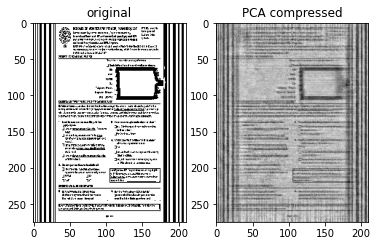

In [83]:
print(np.cumsum(pca.explained_variance_ratio_).max())
idx = random.randint(0, arr.shape[0])
x = arr[idx:idx+5]
x1 = pca.transform(x)
x2 = pca.inverse_transform(x1)
print("reduced shape: " + str(x1.shape))
print("recovered shape: " + str(x2.shape))
import matplotlib.pyplot as plt

f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(x[0].reshape((275,210)), cmap='gray')
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(x2[0].reshape((275,210)), cmap='gray')
plt.show(block=True)

In [4]:
import pickle 

with open('pca_model_raw_20', 'wb') as handle:
    pickle.dump(pca, handle)

In [10]:
out = np.memmap('image_data_raw_20.npy', mode='w+', shape = (150000,20))

n = arr.shape[0] # how many rows we have in the dataset
chunk_size = 5000 # how many rows we feed to IPCA at a time, the divisor of n

for i in range(0, n//chunk_size):
    x = pca.transform(arr[i*chunk_size : (i+1)*chunk_size])
    out[i*chunk_size : (i+1)*chunk_size] = x
    print(f'{i}\t/\t {n//chunk_size}',end='\r',flush=True)
out.flush()

In [2]:
for file in ['gray', 'binary']:
    if file == 'gray':
        arr = np.memmap('image_data_raw.npy',mode='r', shape = (150000,275*210))
    else:
        arr = np.memmap('image_data_binary.npy',mode='r', shape = (150000,275*210))
    for n_components in [20,120,360]:
        n = arr.shape[0] # how many rows we have in the dataset
        chunk_size = 1000 # how many rows we feed to IPCA at a time, the divisor of n
        indices = np.arange(n)
        np.random.shuffle(indices)
        performance_test = {}
        if os.path.exists(f'{file}_model_{n_components}'):
            with open(f'{file}_model_{n_components}', 'rb') as pickle_file:
                pca = pickle.load(pickle_file)
            print(f'{file}_model_{n_components} already trained')
        else:
            for i in range(0, n//chunk_size):
                pca = IncrementalPCA(n_components=n_components,batch_size=chunk_size)
                pca.partial_fit(arr[indices[i*chunk_size : (i+1)*chunk_size]])
                print(f'{i}\t/\t {n//chunk_size}',end='\r',flush=True)
            with open(f'{file}_model_{n_components}', 'wb') as handle:
                pickle.dump(pca, handle)
        
        if not os.path.exists(f'{file}_data_{n_components}'):
            out = np.memmap(f'{file}_data_{n_components}', mode='w+', shape = (n,n_components))
            for i in range(0, n//chunk_size):
                x = pca.transform(arr[i*chunk_size : (i+1)*chunk_size])
                out[i*chunk_size : (i+1)*chunk_size] = x
                print(f'{i}\t/\t {n//chunk_size}',end='\r',flush=True)
            out.flush()
        print(f'\n{file} model {n_components} components done')

gray_model_20 already trained

gray model 20 components done
gray_model_120 already trained

gray model 120 components done
gray_model_360 already trained

gray model 360 components done
binary_model_20 already trained

binary model 20 components done
149	/	 150
binary model 120 components done
149	/	 150
binary model 360 components done


In [58]:
# os.path.exists(f'{file}_model_{n_components}')
os.path.exists(f'binary_model_{360}')
with open(f'binary_model_{360}', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)
# pca = pickle.load(f'gray_model_{20}',)
not os.path.exists(f'{file}_data_{n_components}')

False